In [51]:
import json
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Figure 1: Adaptive mutations accumulate continuously over time in known adaptively-evolving proteins

Plot the estimated number of adaptative mutations over time in the receptor-binding protein and polymerase. Plot both the Bhatt rate and the new method for estimating rates of adaptation, which takes into account recurring mutations at the same codon position.

In [2]:
def readin_virus_config(virus):
    config_json = f'config/adaptive_evo_config_{virus}.json'

    with open(config_json) as json_handle:
        configs = json.load(json_handle)
        
    return configs

In [3]:
def standardize_gene_name_reverse(virus, gene):
    
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {x: configs[x]['virus_gene'] for x in genes}
    
    return gene_names[gene]

In [4]:
def standardize_gene_name(virus, gene):
    configs = readin_virus_config(virus)
    
    genes = ['polymerase', 'membrane_fusion', 'receptor_binding']
    gene_names = {configs[x]['virus_gene']:x for x in genes}
    
    return gene_names[gene]

In [5]:
def get_data_from_both_methods(virus, subtype, gene, window, min_seqs, 
                        midfreq_high, midfreq_low, year_max, year_min):
    """
    Read in the adaptation results from both the standard Bhatt method and the new method. 
    Store data at each time point.
    
    Rate of adaptation analysis (and bootstraps) must already have been run and saved.
    """
    
    all_timepoints = []
    
    if subtype==None:
        virus_subtype = virus
        virus_and_subtype = virus
    else:
        virus_subtype = subtype
        virus_and_subtype = virus+'_'+subtype
    
    bhatt_json_name = f'bhatt_results_nextstrain/{virus_and_subtype}_{gene}_bhatt_analysis_bootstrapped.json'
    if path.exists(bhatt_json_name):
        with open(bhatt_json_name) as bhatt_handle:
            json_dict = json.load(bhatt_handle)
            (bhatt_window_midpoint, bhatt_adaptive_substitutions, 
             bhatt_adaptive_substitutions_per_codon, 
             bhatt_rate_of_adaptation, bhatt_bootstrap_adaptive_substitutions, 
             bhatt_bootstrap_adaptive_substitutions_per_codon, 
             bhatt_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

    else:
        print(f'{virus_and_subtype} {gene} Bhatt analysis has not been run')

    for t in range(len(bhatt_window_midpoint)):
        for x in bhatt_bootstrap_adaptive_substitutions_per_codon:
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': bhatt_window_midpoint[t],
                                   'method': 'bhatt',
                                   'adaptive_subs_per_codon': bhatt_adaptive_substitutions_per_codon[t], 
                                   'bootstrap_adaptive_subs_per_codon': x[t], 
                                   'rate_of_adaptation': bhatt_rate_of_adaptation})
            
    kistler_json_name = f'adaptation_results/results/{virus_and_subtype}_{gene}_{window}_{min_seqs}_adaptation_bootstrapped.json'
    if path.exists(kistler_json_name):
        with open(kistler_json_name) as kistler_handle:
            json_dict = json.load(kistler_handle)
            (kistler_window_midpoint, kistler_adaptive_substitutions, 
             kistler_adaptive_substitutions_per_codon, 
             kistler_rate_of_adaptation, kistler_bootstrap_adaptive_substitutions, 
             kistler_bootstrap_adaptive_substitutions_per_codon, 
             kistler_bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                              json_dict['adaptive_substitutions'], 
                                              json_dict['adaptive_substitutions_per_codon'], 
                                              json_dict['rate_of_adaptation'], 
                                              json_dict['bootstrap_adaptive_substitutions'], 
                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                              json_dict['bootstrap_rate_of_adaptation'])

    else:
        print(f'{virus_and_subtype} {gene} Kistler analysis has not been run')

    for t in range(len(kistler_window_midpoint)):
        for x in kistler_bootstrap_adaptive_substitutions_per_codon:
            all_timepoints.append({'virus': virus, 'subtype': subtype, 'virus_and_subtype': virus_and_subtype, 
                                   'gene': standardize_gene_name(virus, gene), 
                                   'timepoint': kistler_window_midpoint[t],
                                   'method': 'kistler',
                                   'adaptive_subs_per_codon': kistler_adaptive_substitutions_per_codon[t], 
                                   'bootstrap_adaptive_subs_per_codon': x[t], 
                                   'rate_of_adaptation': kistler_rate_of_adaptation})





    return all_timepoints


In [334]:
def plot_virus_over_time(viruses, standard_genes=['polymerase', 'receptor_binding'], exclude=None,
                         window=5, min_seqs=3, midfreq_high=0.75, midfreq_low=0.15, 
                         year_max=None, year_min=None, filename=None):
    
    """
    Plot the accumulation of adaptive mutations over time for the polymerase and receptor-binding protein of each virus.
    
    Plot the results of both methods for estimating the rate of adaptation.
    
    Plot the empirical data points the line fitting them. 
    For the 100 bootstrap iterations, plot just the line fitting the points.
    """
    

    
    data_to_plot = []

    
    #get the data
    for virus in viruses:
        configs = readin_virus_config(virus)
        genes = [standardize_gene_name_reverse(virus, x) for x in standard_genes]
        
        if configs['subtype']=='True':
            subtypes = configs['subtypes']
            for subtype in subtypes:
                virus_and_sub = virus+'_'+subtype
                if virus_and_sub != exclude:
                    for gene in genes:
                        if gene!="None":
                            data_to_plot+=get_data_from_both_methods(virus, subtype, gene, window, 
                                                                 min_seqs, midfreq_high, midfreq_low, year_max, year_min)

        else:
            subtype=None
            if virus != exclude:
                for gene in genes:
                    if gene!="None":
                        data_to_plot+=get_data_from_both_methods(virus, subtype, gene, window, 
                                                             min_seqs, midfreq_high, midfreq_low, year_max, year_min)


    df_to_plot = pd.DataFrame(data_to_plot)
        
    #make the gene label more legible
    legible_titles_genes = {'polymerase': 'Polymerase', 'receptor_binding': 'Receptor-Binding Protein'}
    df_to_plot['gene_title'] = df_to_plot['gene'].map(legible_titles_genes)
    
    #make the virus name more legible
    legible_titles_viruses = {'rsv_A': 'RSV-A', 'rsv_B': 'RSV-B', 
                             '229e': '229E', 'oc43_A': 'OC43-A', 
                             'oc43_B': 'OC43-B', 'nl63': 'NL63', 
                              'measles': 'Measles', 'h3n2': 'H3N2', 
                              'enterovirusd68': 'Enterovirus D68', 'norovirus': 'Norovirus GII.4', 
                              'hepatitisB_A2':'hepatitisB-A2', 
                              'hepatitisB_C':'hepatitisB-C','hepatitisB_D3':'hepatitisB-D3', 
                              'rhinovirusA101':'Rhinovirus A101', 'rhinovirusB6': 'Rhinovirus B6',
                              'hepatitisA_IA': 'Hepatitis A-IA', 'hepatitisA_IB': 'Hepatitis A-IB'}
    df_to_plot['virus_title'] = df_to_plot['virus_and_subtype'].map(legible_titles_viruses)

    #plot text styling
    sns.set_style("white")
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 8
    
    plt.rcParams['figure.dpi']= 300
    
    #initiate plotting axes
    viruses_to_plot = df_to_plot['virus_and_subtype'].unique()
    num_rows_to_plot = len(viruses_to_plot)
    fig, axs = plt.subplots(num_rows_to_plot, 2, figsize=(8, 6), sharey="row", sharex=True)
    
    #colors to use
    color_map = {"kistler": {viruses_to_plot[0]:"#9F2A44", viruses_to_plot[1]:"#208288"}, 
                 "bhatt": {viruses_to_plot[0]:"#E06E85", viruses_to_plot[1]:"#BBE4D1"}}
    
    edgecolor_map = {"kistler": {viruses_to_plot[0]:"#5F1928", viruses_to_plot[1]:"#134E51"}, 
                 "bhatt": {viruses_to_plot[0]:"#B3586A", viruses_to_plot[1]:"#95B6A7"}}

    #figure panel labels
    fig_labels = ['A', 'B', 'C', 'D']
    
    #position for rate text
    text_pos_K = {'x': [0.3, 0.25, 0.5, 0.3], 'y':[0.3, 0.8, 0.35, 0.75]}
    text_pos_B = {'x': [0.2, 0.55, 0.45, 0.65], 'y':[0.2, 0.3, 0.25, 0.25]}
    

    #add each virus and gene to a subplot
    for i in range(len(viruses_to_plot)):
        v = viruses_to_plot[i]
        for j in range(len(standard_genes)):
            #subset the dataframe to get data for just this virus and gene
            g = standard_genes[j]
            subset_data =df_to_plot[(df_to_plot['virus_and_subtype'] == v) & (df_to_plot['gene'] == g)]
            #subset further, by method
            subset_data_bhatt = subset_data[subset_data['method']=='bhatt']
            bhatt_rate = subset_data_bhatt['rate_of_adaptation'].unique()[0]
            bhatt_rate = f'{round(bhatt_rate*1000,2)} x '+ r'$10^{-3}$'
            
            subset_data_kistler = subset_data[subset_data['method']=='kistler']
            kistler_rate = subset_data_kistler['rate_of_adaptation'].unique()[0]
            kistler_rate = f'{round(kistler_rate*1000,2)} x ' + r'$10^{-3}$'
            
            x_B = subset_data_bhatt['timepoint']
            y_B = subset_data_bhatt['adaptive_subs_per_codon']
            #get linear fit
            coef_B = np.polyfit(x_B, y_B, 1)
            poly1d_fn_B = np.poly1d(coef_B)
            
            x_K = subset_data_kistler['timepoint']
            y_K = subset_data_kistler['adaptive_subs_per_codon']
            #get linear fit
            coef_K = np.polyfit(x_K, y_K, 1)
            poly1d_fn_K = np.poly1d(coef_K)
            
            #plot empirical estimates and linear regression for both methods
            axs[i, j].plot(x_B, poly1d_fn_B(x_B), '-', linewidth=2, color=edgecolor_map["bhatt"][v])
            axs[i, j].plot(x_B, y_B, 'o', ms=6, color=color_map["bhatt"][v],
                           markeredgewidth=0.5, markeredgecolor=edgecolor_map["bhatt"][v], 
                           label='Bhatt et al')
            
            axs[i, j].plot(x_K, poly1d_fn_K(x_K), '-', linewidth=2, color=edgecolor_map["kistler"][v])
            axs[i, j].plot(x_K, y_K, 'o', ms=6, color=color_map["kistler"][v], 
                           markeredgewidth=0.5, markeredgecolor=edgecolor_map["kistler"][v], 
                           label='This Paper')
            
            #label the rate of adaptation
            fig_index = 2*i+j
            axs[i, j].text(text_pos_K['x'][fig_index], text_pos_K['y'][fig_index], 
                           f'rate= {kistler_rate}', fontsize=10,
                           color=edgecolor_map["kistler"][v], transform=axs[i, j].transAxes)
            axs[i, j].text(text_pos_B['x'][fig_index], text_pos_B['y'][fig_index], 
                           f'rate= {bhatt_rate}', fontsize=10, 
                           color=edgecolor_map["bhatt"][v], transform=axs[i, j].transAxes)


            
            #add figure panel labels
            axs[i, j].text(-0.07, 1.05, fig_labels[fig_index], horizontalalignment='center', 
                           verticalalignment='center', weight='bold', fontsize=16, transform=axs[i, j].transAxes)


            
            
            #label x-axis on bottom plots only
            if i==1:
                axs[i, j].set_xlabel("Date")
            #label y-axis on left plots only
            if j==0:
                axs[i, j].set_ylabel("Adaptive Mutations \n per Codon")
            
            #put legend to the right of receptor-binding plots
            #label virus and method
            if j==1:
                axs[i, j].text(1.0, 0.1, legible_titles_viruses[v], fontsize=20, horizontalalignment='center', 
                           verticalalignment='center', transform=axs[i, j].transAxes)
                #reoder labels to list This Paper first 
                handles, labels = axs[i, j].get_legend_handles_labels()
                #specify order
                order = [1, 0]

                # pass handle & labels lists along with order as below
#                 plt.legend([handles[i] for i in order], [labels[i] for i in order])
                leg = axs[i,j].legend([handles[i] for i in order], [labels[i] for i in order],
                                      bbox_to_anchor=(1.0, 0.7), frameon=True, 
                                      title= "Method",title_fontproperties={'weight':'bold'})
                #add border    
                leg.get_frame().set_edgecolor('#808080')
                
                
            #add gene label/title above top row
            if i==0:
                axs[i,j].title.set_text(legible_titles_genes[g])
                

    plt.xticks([1970,1980,1990,2000,2010,2020])
    
    fig.tight_layout()
    
    # remove box around plot
    sns.despine(left=False, bottom=False)
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight', transparent=False, facecolor='white')
    




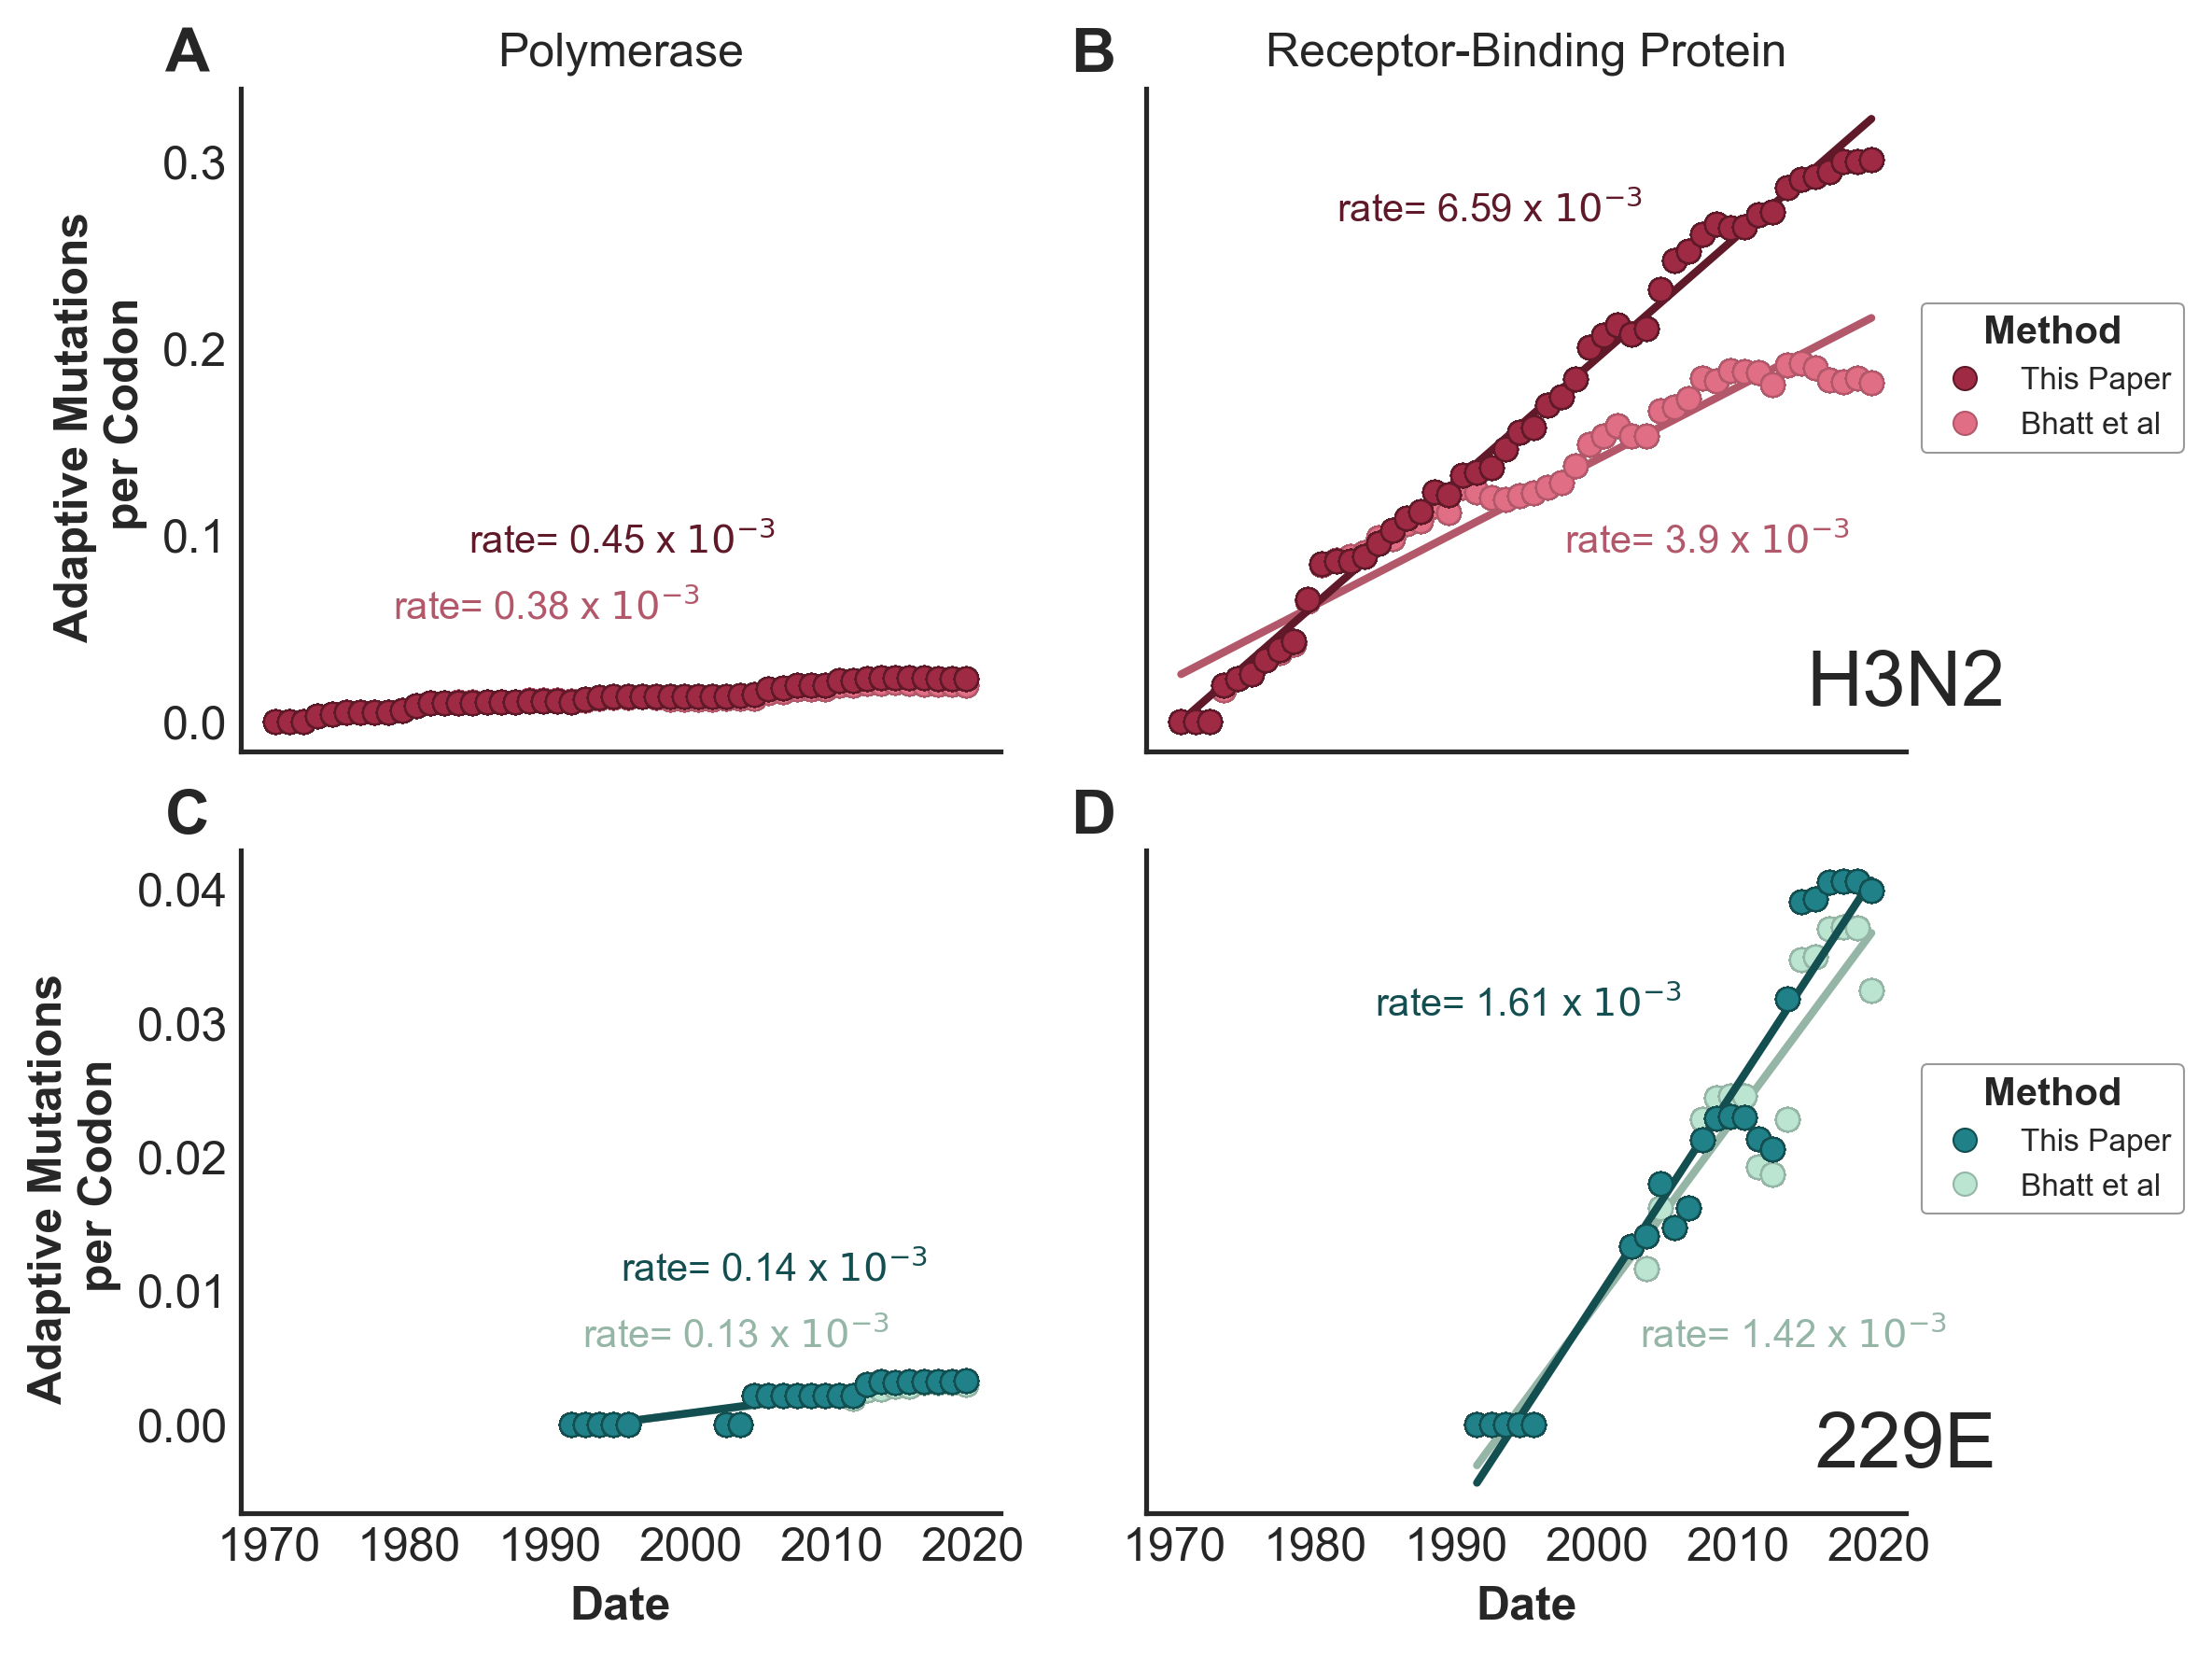

In [335]:
plot_virus_over_time(['h3n2', '229e'], filename = 'manuscript_figures/Figure1.png')